## Text Classification
<b>Rohit Vincent - therohitvincent@gmail.com<br>

#### Import Required Libraries

In [1]:
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import cross_validate,train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import SVC
import random
import seaborn as sns

In [2]:
# Random seed to replicate
random.seed(60)
# Inline plotting
%matplotlib inline
# Use Seaborn
sns.set()

<b>Following javascript code is to disable the scroll function for the output of the notebook</b>

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

#### Categories chosen

The datasets used for classification are reviews on Bars & Restaurants. Both of them are places where people go to eat. Hence reviews should have common features. Due to the similarity between these two datasets, We hypothesis that a good accuracy could be attained for transfer learning on the models created.

In [4]:
category1 = "bars_list"
category2 = "restaurants_list"
yalp_prefix = "http://mlg.ucd.ie/modules/yalp/"

#### Define Function for Plotting

In [5]:
# Define Generate Random Colours
def getColors(length):
    colors = list()
    for i in range(length):
        colors.append(list(np.random.rand(3,)))
    return colors

# Function to plot bar graph
def plot_graph(Dictionary,mytitle,ytitle="Accuracy",prune=False):
    ys = sorted(Dictionary.values(), reverse=True)
    labels = sorted(Dictionary, key=Dictionary.get, reverse=True)
    xs = np.arange(len(labels)) 
    # Set title
    plt.figure(figsize=(15,7))
    plt.title(mytitle, fontsize=15)
    plt.bar(xs, ys,align='center', color=getColors(len(xs)),tick_label=ys)
    plt.xticks(xs, labels) #Replace default x-ticks with xs, then replace xs with labels
    plt.xlabel("Classifier Type")
    plt.yticks(ys)
    plt.ylabel(ytitle)
    plt.xticks(rotation=90)
    plt.tick_params(axis='y', which='major')
    # To ensure differences are scene start y value close to first value
    plt.ylim(bottom=ys[-1]-0.01)
    # Prune y axis to avoid overlap
    if prune:
        new_y=[]
        for i,y in enumerate(ys):
            if i==0: 
                prev = y
                new_y.append(prev)
                continue;
            if(prev-y > 0.005):
                new_y.append(y)
            prev=y
        plt.yticks(new_y)
    plt.show()

## TASK 1: Fetch Reviews for a category

Function to parse the web server and get a dataframe consisting of reviews & ratings.<br>
All ratings less than 4-stars are considered negative.<br>
This dataframe is saved to the disk.<br>

In [6]:
def fetchData(category,prefix):
    # Map Labels to Positive/Negative
    map_rating = {'1-star':"negative",
                      '2-star':"negative",
                      '3-star':"negative",
                      '4-star':"positive",
                      '5-star':"positive"}
    # Fetch html page
    resp = requests.get(prefix+category)
    # Create soup of response text
    soup = BeautifulSoup(resp.text, 'html')
    # Define column names for our new dataframe
    columns = ['review','rating']
    # Create dataframe with columns
    df = pd.DataFrame(columns=columns)
    # For each listing in the category
    for link in soup.find_all('a'):
        # Fetch link to review for listing
        resp = requests.get(prefix+link.attrs['href'])
        # Create soup of response text
        soup = BeautifulSoup(resp.text, 'html')
        # Fetch all divs in the html with class review
        reviews = soup.find_all('div',class_="review")
        # For each div review class
        for review in reviews:
            # Fetch p element with class text
            text = review.find_all('p',class_="text")[0].text
            # Fetch img element with alt 
            rating = review.find_all('img',alt=True)[0]['alt']
            # Store all details in dataframe    
            df.loc[len(df)]=[text,rating]
    # Replace ratings into negative or positive
    df['rating'] = df['rating'].map(map_rating)
    # Save the data to csv
    df.to_csv(category+".csv", index= False)

Store the files

In [7]:
# Fetch & Store data for Bars
fetchData(category1,yalp_prefix)
# Fetch & Store data for Restaurants
fetchData(category2,yalp_prefix)

## Reviews for Bars

In [8]:
dataset1 = pd.read_csv(category1+".csv")

Check the data for bars

In [9]:
dataset1.head()

,review,rating
0,It would help if the front girl don't just sit...,negative
1,One star because that's the least amount you c...,negative
2,"Bad time today. Dirty windows, table sticky, h...",negative
3,My second visit in the last year. Both experie...,negative
4,"Absolutely awful! Took forever to get food, fo...",negative


Number of reviews for Bars

In [10]:
dataset1.shape[0]

1460

Distribution of ratings

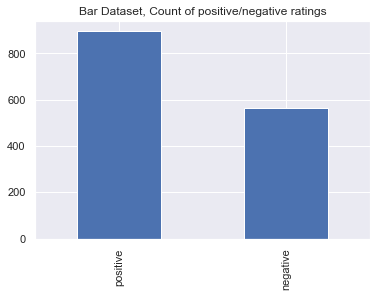

In [11]:
dataset1.rating.value_counts().plot(kind='bar',title='Bar Dataset, Count of positive/negative ratings')

## Reviews for Restaurants

In [12]:
dataset2 = pd.read_csv(category2+".csv")

Check the dataset for restaurants

In [13]:
dataset2.head()

,review,rating
0,Too expensive for what they had... i had an eg...,negative
1,"Very rustic place. Mismatched furniture, off K...",positive
2,I highly recommend Au Festin de Babette for th...,positive
3,Amazing soup and dauphinoise. BUT the wait for...,negative
4,I went here by recommendation of a friend. Tho...,negative


Number of reviews for restaurant

In [14]:
dataset2.shape[0]

1440

Distribution of ratings

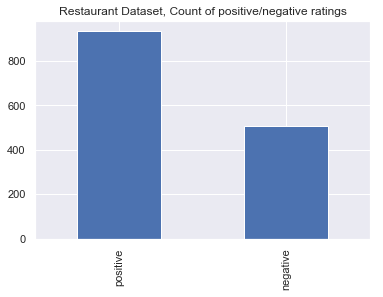

In [15]:
dataset2.rating.value_counts().plot(kind='bar',title='Restaurant Dataset, Count of positive/negative ratings')

We can see that both datasets are imbalanced.

# Task 2

## Pre-Processing & Feature Extraction Vectorizer

Create a vectorizer which does the following pre-processing:
 1. Strip accents to get a normalised form of the text using unicode encoding. (Implicit function call attribute strip_accents)
 2. Convert all words to lower case. (Implicit function call attribute lowercase)
 3. Remove english stopwords (Achieved in custom tokenization function, did not use implicit call in order to stem)
 4. Stem words to root form (Achieved in custom tokenization function)
 5. Standard pre-processing of removing junk characters is achieved in the default tokenizer used in the custom tokenization function

In [16]:
# Get stop word list
stopwords_list = stopwords.words('english')
# Fetch default tokenizer for Tfidf Vectorizer
standard_tokenizer = TfidfVectorizer().build_tokenizer()
# Use NLTK Porter Stemmer to perform stemming
stemmer = PorterStemmer()
# Custom tokenization function which does stemming & stop word removal 
# Implicit stop word removal was not done since the standard vectorizer pipeline calls 
# stop word removal after tokenization(stemming)
def custom_tokenizer(text):
    # Tokenize the text
    tokens = standard_tokenizer(text)
    stems = []
    # For each token
    for token in tokens:
        # Only accept token if it is not a stop word
        if token not in stopwords_list:
        # Stem the token to root form and add to list
            stems.append( stemmer.stem(token) )
    return stems

Create the vectorizer
1. Default vectorizer used for most classifiers which include the default preprocessing steps mentioned above for unigram features.
2. Vectorizer which uses all preprocessing steps other than stemming to generate unigram features.
3. Vectorizer used for most classifiers which include the default preprocessing steps mentioed above for unigrams + bigrams.

In [17]:
# Default vectorizer with stemming for unigrams
vectorizer = TfidfVectorizer(min_df = 10,strip_accents='unicode',sublinear_tf=True,tokenizer=custom_tokenizer,lowercase=True)
# Vectorizer without stemming for unigrams
vectorizer_nostem = TfidfVectorizer(min_df = 10,strip_accents='unicode',sublinear_tf=True,stop_words='english',lowercase=True)
# Default vectorizer with stemming for unigrams & bigrams
vectorizer_bi = TfidfVectorizer(min_df = 10,strip_accents='unicode',sublinear_tf=True,tokenizer=custom_tokenizer,lowercase=True,ngram_range=(1,2))

## Create Classifier for Bars

Get data & labels for bars

In [18]:
data = dataset1.review 
target = dataset1.rating

### Divide dataset into training & testing (20% of dataset for testing)

In [19]:
# The split is stratified meaning it will have equal number of both target classes in the training/test set
X, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,stratify=target,random_state=60)
print("Training set has %d samples" % X.shape[0])
print("Test set has %d samples" % X_test.shape[0])

Training set has 1168 samples
Test set has 292 samples


### Numeric representation(Sample) of Bars

In [20]:
# Learn Vocabulary & Transform words into TDIDF matrix
X_train = vectorizer.fit_transform(X)
print(X_train[:-1,-1])

  (33, 0)	0.2933904336336218
  (34, 0)	0.20708764728686907
  (35, 0)	0.0946053127428619
  (155, 0)	0.23332452491679498
  (317, 0)	0.19202049996751033
  (360, 0)	0.14001727832278815
  (391, 0)	0.22962820103149836
  (448, 0)	0.19136522246910023
  (482, 0)	0.11898331334779837
  (530, 0)	0.10949800187565903
  (629, 0)	0.19081613310281847
  (643, 0)	0.23594019823702803
  (685, 0)	0.09428671772967026
  (697, 0)	0.2584135151411138
  (703, 0)	0.2053522350682296
  (780, 0)	0.29613945708369904
  (801, 0)	0.28990490656318946
  (821, 0)	0.2945936265614037
  (856, 0)	0.20408711365740714
  (868, 0)	0.1198478387996109
  (878, 0)	0.16390721713767448
  (989, 0)	0.11439164240835521
  (1083, 0)	0.09824721107266847
  (1093, 0)	0.2500983673255697
  (1134, 0)	0.10865973269721713
  (1156, 0)	0.22692797746114587


In [21]:
# Fetch Features
terms = vectorizer.get_feature_names()
print("Vocabulary has %d features" % len(terms))

Vocabulary has 1043 features


#### Top 10 Features

In [22]:
# sum over the columns
freqs = X_train.sum(axis=0)
# sort indexes by value
sorted_term_indexes = freqs.argsort()
# reverse it
sorted_term_indexes = sorted_term_indexes[0, ::-1]
# display the top 10 terms
for i in range(10):
    term_index = sorted_term_indexes[0,i]
    print(terms[term_index])

food
great
place
good
servic
time
bar
go
order
drink


### Model 1: Naive Bayes Classifier

In [23]:
# Declare Naive Bayes Model
bar_model = ComplementNB()
# Train the model using training set
bar_model.fit(X_train, y_train)
# Convert Test Set into TD-IDF representation
Xtest = vectorizer.transform(X_test) 
# Test the model using rest 20%
predicted = bar_model.predict(Xtest)

##### Test model 1 with some examples from the dataset

Actual Ratings

In [24]:
display(pd.crosstab( data[-4:], target[-4:], rownames=['Reviews'], colnames=['Actual Rating'], margins=True))

Actual Rating,negative,positive,All
Reviews,,,
"Fresh and tasty new dishes, really friendly staff. Super cool design and flow, great atmosphere and menu! Will def be back, lots of authentic but new school asian dishes.",0,1,1
"Great foods, great service, and nice presentation. I had the curry custard and it was very yummy. I was hoping to bring the coconut home but that didn't happen. Would b nice to keep my leftovers in the coconut (w a branded logo), what a great way to advertise their restaurant?",0,1,1
"There are so many great places to eat in Scottsdale and this is not one of them. The staff was awkward and the food was very bland. Not what we were expecting from a place with ""culinary"" in the name.",1,0,1
"We came here on a Friday night Dec 2. Didn't realize it until I read other reviews that today was their grand opening. Walking up to the Zen, the patio tables looking very enticing but cold outside. As you walk in the front door is a nice little waterfall. Nice touch. Anyways, they have a huge dining area. Bar area with lots of seating and a dining area. Very bright with red and orange. Very well decorated, wide open feeling with a somewhat touch of Asian. Bar area has three large tv's with large windows where you can see the kitchen. Anyways, we dined in the dining area with the booths. We were greeted right away with our water cups. We started off with the Tuna Mango Poke. It had a whole avocado cut in half with Tuna Poke and Mango. Very well presented. It was good but lacked a little flavor. I had the Pad Thai with beef. It had on the side, peanuts and dry peppers to spice it up. I thought it was pretty good. Not too sweet. For those of you that like your really spicy Thai food, probably wouldn't be spicy enough for you but I really liked it. Decent portion. My wife had the Noodle soup with chicken. She really likes it and I was able to sneak a few bites and it was pretty good. The noodles were good and the soup was really good for a chilly night. My son had the baby back ribs. He liked it. The sauce had a little Asian flare to it with crispy fries. He ate it all up so it must have been pretty good. Service was pretty good. He was always checking on us and made sure our water cups were filled. So Zen had pretty good food, good service, and a pretty unique ambiance about this place. I will tell you what, this place has Japanese, Vietnamese, Thai, and American food in a unique setting. Now if you want original Asian food then this place isn't for you. Keep an open mind and just enjoy. I know they have some kinks but I'm sure they will fix them. I'm looking forward to coming back and trying other dishes on the menu. Enjoy. I sure did.",0,1,1
All,1,3,4


Predicted Ratings

In [25]:
test_data = vectorizer.transform(data[-4:])
pred = bar_model.predict(test_data)
display(pd.crosstab( data[-4:],pred,rownames=['Reviews'], colnames=['Predicted Rating'], margins=True))

Predicted Rating,negative,positive,All
Reviews,,,
"Fresh and tasty new dishes, really friendly staff. Super cool design and flow, great atmosphere and menu! Will def be back, lots of authentic but new school asian dishes.",0,1,1
"Great foods, great service, and nice presentation. I had the curry custard and it was very yummy. I was hoping to bring the coconut home but that didn't happen. Would b nice to keep my leftovers in the coconut (w a branded logo), what a great way to advertise their restaurant?",0,1,1
"There are so many great places to eat in Scottsdale and this is not one of them. The staff was awkward and the food was very bland. Not what we were expecting from a place with ""culinary"" in the name.",1,0,1
"We came here on a Friday night Dec 2. Didn't realize it until I read other reviews that today was their grand opening. Walking up to the Zen, the patio tables looking very enticing but cold outside. As you walk in the front door is a nice little waterfall. Nice touch. Anyways, they have a huge dining area. Bar area with lots of seating and a dining area. Very bright with red and orange. Very well decorated, wide open feeling with a somewhat touch of Asian. Bar area has three large tv's with large windows where you can see the kitchen. Anyways, we dined in the dining area with the booths. We were greeted right away with our water cups. We started off with the Tuna Mango Poke. It had a whole avocado cut in half with Tuna Poke and Mango. Very well presented. It was good but lacked a little flavor. I had the Pad Thai with beef. It had on the side, peanuts and dry peppers to spice it up. I thought it was pretty good. Not too sweet. For those of you that like your really spicy Thai food, probably wouldn't be spicy enough for you but I really liked it. Decent portion. My wife had the Noodle soup with chicken. She really likes it and I was able to sneak a few bites and it was pretty good. The noodles were good and the soup was really good for a chilly night. My son had the baby back ribs. He liked it. The sauce had a little Asian flare to it with crispy fries. He ate it all up so it must have been pretty good. Service was pretty good. He was always checking on us and made sure our water cups were filled. So Zen had pretty good food, good service, and a pretty unique ambiance about this place. I will tell you what, this place has Japanese, Vietnamese, Thai, and American food in a unique setting. Now if you want original Asian food then this place isn't for you. Keep an open mind and just enjoy. I know they have some kinks but I'm sure they will fix them. I'm looking forward to coming back and trying other dishes on the menu. Enjoy. I sure did.",0,1,1
All,1,3,4


### Evaluate Model 1

#### Confusion Matrix

The confusion matrix shows the amount of predictions which were correct for each label. We have more than 10 items misclassified as positive when they were actually negative. Around 20+ items were misclassified as negative when they were actually positive.

In [26]:
display(pd.crosstab(np.array(y_test), predicted, rownames=['Actual'], colnames=['Predicted'], margins=True))

Predicted,negative,positive,All
Actual,,,
negative,98,15,113
positive,23,156,179
All,121,171,292


#### Accuracy/F1 Score of the model on test set

F1 score shows the harmonic mean between the precision & recall. The classifier has a good F1-Score as well as a good score of accuracy.

In [27]:
acc_score = metrics.accuracy_score(y_test, predicted)
f1_score = metrics.f1_score(y_test, predicted, average='macro')
print('Total accuracy classification score: '+str(acc_score))
print('Total F1 classification score: '+str(f1_score))

Total accuracy classification score: 0.8698630136986302
Total F1 classification score: 0.8645177045177045


### Model 2: K Nearest Neighbour

In [28]:
# Create Model for K-Nearest Neighbour for 8 neighbours
bar_model2 = KNeighborsClassifier(n_neighbors=8,p=2,n_jobs=-1)
# Train Model on training data
bar_model2.fit(X_train,y_train)
# Predict using the model on test data
predicted2 = bar_model2.predict(Xtest)

### Evaluate Model 2

#### Confusion Matrix

The confusion matrix shows the amount of predictions which were correct for each label. We can see that we have 25+ items misclassified as positive when they were actually negative. We can see there are less items misclassified as negative when they were actually positive.

In [29]:
display(pd.crosstab(np.array(y_test), predicted2, rownames=['Actual'], colnames=['Predicted'], margins=True))

Predicted,negative,positive,All
Actual,,,
negative,86,27,113
positive,24,155,179
All,110,182,292


#### Accuracy/F1 Score of the model 2 on test set

F1 score shows the harmonic mean between the precision & recall. The classifier has an average of 80%. This shows that model 2 is not as good as model 1 for classification.

In [30]:
acc_score = metrics.accuracy_score(y_test, predicted2)
f1_score = metrics.f1_score(y_test, predicted2, average='macro')
print('Total accuracy classification score: '+str(acc_score))
print('Total F1 classification score: '+str(f1_score))

Total accuracy classification score: 0.8253424657534246
Total F1 classification score: 0.8150131051016731


### Model 3: Passive Aggressive Classifier

In [31]:
# Create Model for Passive Aggressive Classifier
bar_model3 = PassiveAggressiveClassifier(max_iter=10000, random_state=60,tol=1e-3)
# Train Model on training data
bar_model3.fit(X_train,y_train)
# Predict using the model on test data
predicted3 = bar_model3.predict(Xtest)

### Evaluate Model 3

#### Confusion Matrix

In [32]:
display(pd.crosstab(np.array(y_test), predicted3, rownames=['Actual'], colnames=['Predicted'], margins=True))

Predicted,negative,positive,All
Actual,,,
negative,92,21,113
positive,24,155,179
All,116,176,292


#### Accuracy/F1 Score of the model 3 on test set

F1 score shows the harmonic mean between the precision & recall. The classifier has an average F1-Score of 84% with an accuracy of 84%. This shows that model 3 is better than model 2 but not as good as model 1 for classification.

In [33]:
acc_score = metrics.accuracy_score(y_test, predicted3)
f1_score = metrics.f1_score(y_test, predicted3, average='macro')
print('Total accuracy classification score: '+str(acc_score))
print('Total F1 classification score: '+str(f1_score))

Total accuracy classification score: 0.8458904109589042
Total F1 classification score: 0.838366443200689


### Model 4: SVM

In [34]:
# Create Model for SVM
bar_model4 = SVC(gamma='scale')
# Train Model on training data
bar_model4.fit(X_train,y_train)
# Predict using the model on test data
predicted4 = bar_model4.predict(Xtest)

### Evaluate Model 4

#### Confusion Matrix

In [35]:
display(pd.crosstab(np.array(y_test), predicted4, rownames=['Actual'], colnames=['Predicted'], margins=True))

Predicted,negative,positive,All
Actual,,,
negative,90,23,113
positive,12,167,179
All,102,190,292


#### Accuracy/F1 Score of the model 4 on test set

In [36]:
acc_score = metrics.accuracy_score(y_test, predicted4)
f1_score = metrics.f1_score(y_test, predicted4, average='macro')
print('Total accuracy classification score: '+str(acc_score))
print('Total F1 classification score: '+str(f1_score))

Total accuracy classification score: 0.8801369863013698
Total F1 classification score: 0.8711791769080481


### Model 5: SVM without stemming

In [37]:
# Learn Vocabulary & Transform words into TDIDF matrix using a different vectorizer with no stemming
X_train = vectorizer_nostem.fit_transform(X)
# Create Model for SVM
bar_model5 = SVC(gamma='scale')
# Train Model on training data
bar_model5.fit(X_train,y_train)
# Convert Test Set into TD-IDF representation
Xtest = vectorizer_nostem.transform(X_test) 
# Predict using the model on test data
predicted5 = bar_model5.predict(Xtest)

### Evaluate Model 5

#### Confusion Matrix

In [38]:
display(pd.crosstab(np.array(y_test), predicted5, rownames=['Actual'], colnames=['Predicted'], margins=True))

Predicted,negative,positive,All
Actual,,,
negative,88,25,113
positive,12,167,179
All,100,192,292


#### Accuracy/F1 Score of the model 5 on test set

In [39]:
acc_score = metrics.accuracy_score(y_test, predicted5)
f1_score = metrics.f1_score(y_test, predicted5, average='macro')
print('Total accuracy classification score: '+str(acc_score))
print('Total F1 classification score: '+str(f1_score))

Total accuracy classification score: 0.8732876712328768
Total F1 classification score: 0.8632803107955911


### Model 6: SVM with unigrams & bigram features

In [40]:
# Learn Vocabulary & Transform words into TDIDF matrix using a different vectorizer 
X_train = vectorizer_bi.fit_transform(X)
# Create Model for SVM
bar_model6 = SVC(gamma='scale')
# Train Model on training data
bar_model6.fit(X_train,y_train)
# Convert Test Set into TD-IDF representation
Xtest = vectorizer_bi.transform(X_test)
# Save test set for transfer learning test
Bar_test = Xtest
Bar_test_label = y_test
# Predict using the model on test data
predicted6 = bar_model6.predict(Xtest)

### Evaluate Model 6

#### Confusion Matrix

In [41]:
display(pd.crosstab(np.array(y_test), predicted6, rownames=['Actual'], colnames=['Predicted'], margins=True))

Predicted,negative,positive,All
Actual,,,
negative,88,25,113
positive,8,171,179
All,96,196,292


#### Accuracy/F1 Score of the model 6 on test set

In [42]:
acc_score = metrics.accuracy_score(y_test, predicted6)
f1_score = metrics.f1_score(y_test, predicted6, average='macro')
print('Total accuracy classification score: '+str(acc_score))
print('Total F1 classification score: '+str(f1_score))

Total accuracy classification score: 0.886986301369863
Total F1 classification score: 0.8770526315789473


### Model 7: Naive Bayes with unigrams & bigram features

In [43]:
# Create Model for Naive Bayes
bar_model7 = ComplementNB()
# Train Model on training data
bar_model7.fit(X_train,y_train)
# Predict using the model on test data
predicted7 = bar_model7.predict(Xtest)

### Evaluate Model 7

#### Confusion Matrix

In [44]:
display(pd.crosstab(np.array(y_test), predicted7, rownames=['Actual'], colnames=['Predicted'], margins=True))

Predicted,negative,positive,All
Actual,,,
negative,99,14,113
positive,28,151,179
All,127,165,292


#### Accuracy/F1 Score of the model 7 on test set

In [45]:
acc_score = metrics.accuracy_score(y_test, predicted7)
f1_score = metrics.f1_score(y_test, predicted7, average='macro')
print('Total accuracy classification score: '+str(acc_score))
print('Total F1 classification score: '+str(f1_score))

Total accuracy classification score: 0.8561643835616438
Total F1 classification score: 0.851453488372093


### ROC/AUC for Models

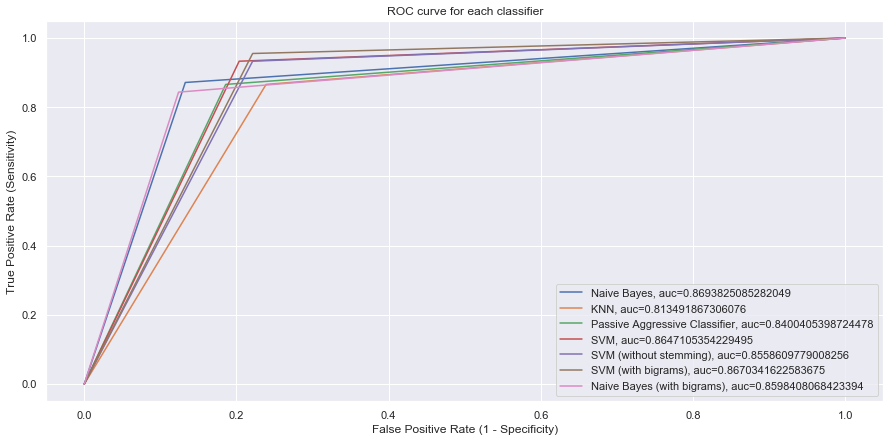

In [46]:
# Map rating to binary values
y_test_bin = y_test.replace({'positive':1,'negative':0})
pred_bin = pd.DataFrame(predicted).replace({'positive':1,'negative':0})
pred2_bin = pd.DataFrame(predicted2).replace({'positive':1,'negative':0})
pred3_bin = pd.DataFrame(predicted3).replace({'positive':1,'negative':0})
pred4_bin = pd.DataFrame(predicted4).replace({'positive':1,'negative':0})
pred5_bin = pd.DataFrame(predicted5).replace({'positive':1,'negative':0})
pred6_bin = pd.DataFrame(predicted6).replace({'positive':1,'negative':0})
pred7_bin = pd.DataFrame(predicted7).replace({'positive':1,'negative':0})
plt.figure(figsize=(15,7))
# Plot ROC curve
plt.rcParams['font.size'] = 12
plt.title('ROC curve for each classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
# Fetch ROC & AUC for Naive Bayes Classification
fpr, tpr, thresh = metrics.roc_curve(y_test_bin, pred_bin)
auc = metrics.roc_auc_score(y_test_bin, pred_bin)
plt.plot(fpr,tpr,label="Naive Bayes, auc="+str(auc))
# Fetch ROC & AUC for KNN Classification
fpr, tpr, thresh = metrics.roc_curve(y_test_bin, pred2_bin)
auc = metrics.roc_auc_score(y_test_bin, pred2_bin)
plt.plot(fpr,tpr,label="KNN, auc="+str(auc))
# Fetch ROC & AUC for Passive Aggressive Classification
fpr, tpr, thresh = metrics.roc_curve(y_test_bin, pred3_bin)
auc = metrics.roc_auc_score(y_test_bin, pred3_bin)
plt.plot(fpr,tpr,label="Passive Aggressive Classifier, auc="+str(auc))
# Fetch ROC & AUC for SVM
fpr, tpr, thresh = metrics.roc_curve(y_test_bin, pred4_bin)
auc = metrics.roc_auc_score(y_test_bin, pred4_bin)
plt.plot(fpr,tpr,label="SVM, auc="+str(auc))
# Fetch ROC & AUC for SVM without stemming
fpr, tpr, thresh = metrics.roc_curve(y_test_bin, pred5_bin)
auc = metrics.roc_auc_score(y_test_bin, pred5_bin)
plt.plot(fpr,tpr,label="SVM (without stemming), auc="+str(auc))
# Fetch ROC & AUC for SVM including bigram features
fpr, tpr, thresh = metrics.roc_curve(y_test_bin, pred6_bin)
auc = metrics.roc_auc_score(y_test_bin, pred6_bin)
plt.plot(fpr,tpr,label="SVM (with bigrams), auc="+str(auc))
# Fetch ROC & AUC for Naive Bayes including bigram features
fpr, tpr, thresh = metrics.roc_curve(y_test_bin, pred7_bin)
auc = metrics.roc_auc_score(y_test_bin, pred7_bin)
plt.plot(fpr,tpr,label="Naive Bayes (with bigrams), auc="+str(auc))
plt.legend(loc=0)
plt.show()

The above figure shows us that even though SVM with bigrams has higher accuracy, Naive Bayes performs much better than the other classifiers with a high early true positive rate for lower false positive rates. Higher AUC also shows that Naive Bayes classifier is better. This could be because of the specific test set chosen, hence for a better comparison we perform a 10-fold validation as shown below.

### Evaluate & Compare Classifiers For Bar Dataset

To Compare the models, we use a cross validation using a 10-fold validation and compare the performance to confirm which is the better model.

##### Naive Bayes Classifier

#### Average Accuracy of Model 1 using a 10-fold Cross Validation

In [47]:
scores = dict()
f1_scores = dict()
# Get numerical form of dataset based on model features
X = vectorizer.transform(data)
# Metrics
scoring = ['accuracy', 'f1_macro']
# Perform Cross Validation
score=cross_validate(bar_model, X, target, cv=10, scoring=scoring, n_jobs=-1,return_train_score=False)
# Store for plotting
scores['Naive_Bayes'] = np.mean(score['test_accuracy'])
print("Accuracy : ",np.mean(score['test_accuracy']), " +/- ", np.std(score['test_accuracy']))
# Store for plotting
f1_scores['Naive_Bayes'] = np.mean(score['test_f1_macro'])
print("F1-Score : ",np.mean(score['test_f1_macro']), " +/- ", np.std(score['test_f1_macro']))

Accuracy :  0.8363265306122448  +/-  0.03043488950557057
F1-Score :  0.8295453375967984  +/-  0.03191162792728049


##### K Nearest Neighbour

#### Average Accuracy of Model 2 using a 10-fold Cross Validation

In [48]:
# Perform Cross Validation
score=cross_validate(bar_model2, X, target, cv=10, scoring=scoring, n_jobs=-1,return_train_score=False)
# Store for plotting
scores['KNN'] = np.mean(score['test_accuracy'])
print("Accuracy : ",np.mean(score['test_accuracy']), " +/- ", np.std(score['test_accuracy']))
# Store for plotting
f1_scores['KNN'] = np.mean(score['test_f1_macro'])
print("F1-Score : ",np.mean(score['test_f1_macro']), " +/- ", np.std(score['test_f1_macro']))

Accuracy :  0.7596481351161154  +/-  0.03972247375213797
F1-Score :  0.7480539278886845  +/-  0.040653315828349336


##### Passive Aggressive Classifier

#### Average Accuracy of Model 3 using a 10-fold Cross Validation

In [49]:
# Perform Cross Validation
score=cross_validate(bar_model3, X, target, cv=10, scoring=scoring, n_jobs=-1,return_train_score=False)
# Store for plotting
scores['Passive Aggressive'] = np.mean(score['test_accuracy'])
print("Accuracy : ",np.mean(score['test_accuracy']), " +/- ", np.std(score['test_accuracy']))
# Store for plotting
f1_scores['Passive Aggressive'] = np.mean(score['test_f1_macro'])
print("F1-Score : ",np.mean(score['test_f1_macro']), " +/- ", np.std(score['test_f1_macro']))

Accuracy :  0.7985831574008914  +/-  0.03664566739184611
F1-Score :  0.7884054266257957  +/-  0.03799569535811975


##### SVM

#### Average Accuracy of Model 4 using a 10-fold Cross Validation

In [50]:
# Perform Cross Validation
score=cross_validate(bar_model4, X, target, cv=10, scoring=scoring, n_jobs=-1,return_train_score=False)
# Store for plotting
scores['SVM'] = np.mean(score['test_accuracy'])
print("Accuracy : ",np.mean(score['test_accuracy']), " +/- ", np.std(score['test_accuracy']))
# Store for plotting
f1_scores['SVM'] = np.mean(score['test_f1_macro'])
print("F1-Score : ",np.mean(score['test_f1_macro']), " +/- ", np.std(score['test_f1_macro']))

Accuracy :  0.8411165845648604  +/-  0.03468759591264589
F1-Score :  0.8278052188864479  +/-  0.03607709139960988


##### SVM without stemming

#### Average Accuracy of Model 5 using a 10-fold Cross Validation

In [51]:
# Get numerical form of dataset based on model features
X = vectorizer_nostem.transform(data)
# Perform Cross Validation
score=cross_validate(bar_model5, X, target, cv=10, scoring=scoring, n_jobs=-1,return_train_score=False)
# Store for plotting
scores['SVM without stemming'] = np.mean(score['test_accuracy'])
print("Accuracy : ",np.mean(score['test_accuracy']), " +/- ", np.std(score['test_accuracy']))
# Store for plotting
f1_scores['SVM without stemming'] = np.mean(score['test_f1_macro'])
print("F1-Score : ",np.mean(score['test_f1_macro']), " +/- ", np.std(score['test_f1_macro']))

Accuracy :  0.8417499413558526  +/-  0.02879847365631664
F1-Score :  0.8266752014925751  +/-  0.033964870332814284


##### SVM with bigram

#### Average Accuracy of Model 6 using a 10-fold Cross Validation

In [52]:
# Get numerical form of dataset based on model features
X = vectorizer_bi.transform(data)
# Perform Cross Validation
score=cross_validate(bar_model6, X, target, cv=10, scoring=scoring, n_jobs=-1,return_train_score=False)
# Store for plotting
scores['SVM with bigrams'] = np.mean(score['test_accuracy'])
print("Accuracy : ",np.mean(score['test_accuracy']), " +/- ", np.std(score['test_accuracy']))
# Store for plotting
f1_scores['SVM with bigrams'] = np.mean(score['test_f1_macro'])
print("F1-Score : ",np.mean(score['test_f1_macro']), " +/- ", np.std(score['test_f1_macro']))

Accuracy :  0.8438470560638048  +/-  0.028446295093382666
F1-Score :  0.8303024204171562  +/-  0.029549228661009775


##### Naive Bayes with bigram

#### Average Accuracy of Model 7 using a 10-fold Cross Validation

In [53]:
# Perform Cross Validation
score=cross_validate(bar_model7, X, target, cv=10, scoring=scoring, n_jobs=-1,return_train_score=False)
# Store for plotting
scores['Naive Bayes with bigrams'] = np.mean(score['test_accuracy'])
print("Accuracy : ",np.mean(score['test_accuracy']), " +/- ", np.std(score['test_accuracy']))
# Store for plotting
f1_scores['Naive Bayes with bigrams'] = np.mean(score['test_f1_macro'])
print("F1-Score : ",np.mean(score['test_f1_macro']), " +/- ", np.std(score['test_f1_macro']))

Accuracy :  0.8350129017124092  +/-  0.041867577939015126
F1-Score :  0.8289732423437315  +/-  0.04178256247389615


#### Compare All Models for the dataset

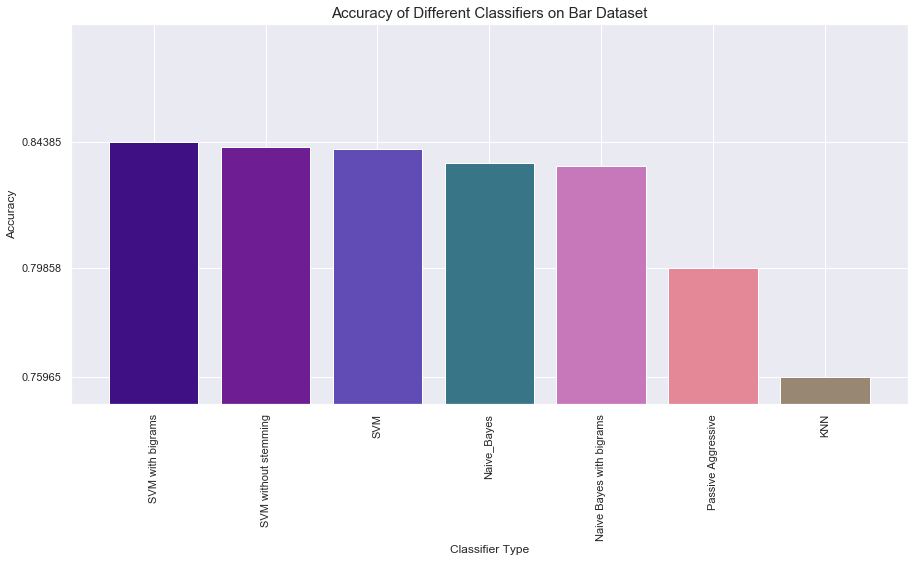

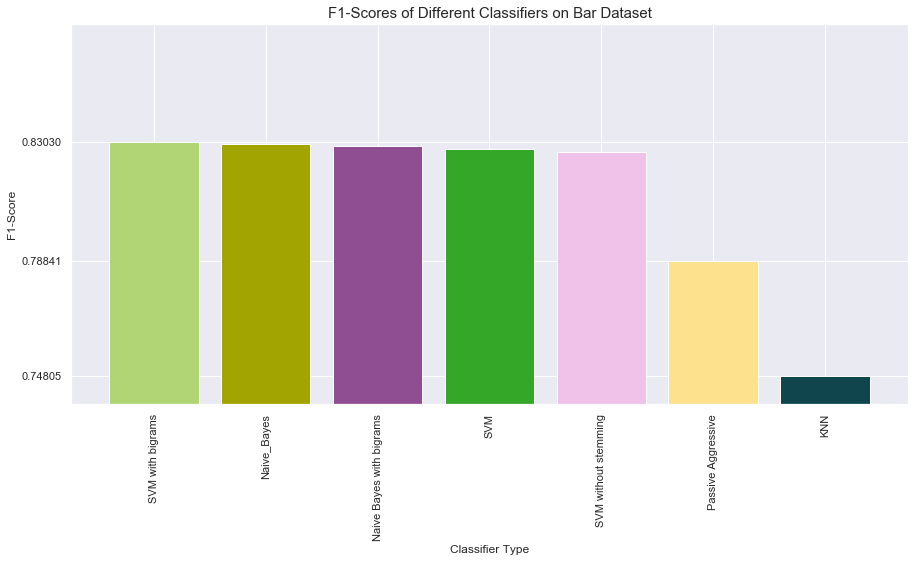

In [54]:
plot_graph(scores,"Accuracy of Different Classifiers on Bar Dataset",prune=True)
plot_graph(f1_scores,"F1-Scores of Different Classifiers on Bar Dataset",ytitle="F1-Score",prune=True)

We can see that SVM with unigrams + bigrams outperforms the other classifiers on a 10-fold cross validation and can be chosen as the best model for the dataset.
Store the best model for later use.

In [55]:
best_bar_model = bar_model6
bar_vectorizer = vectorizer_bi

## Create Classifier for Restaurants

Get data & labels for bars

In [56]:
data_2 = dataset2.review 
target_2 = dataset2.rating

### Divide dataset into training & testing (20% of dataset for testing)

In [57]:
# The split is stratified meaning it will have equal number of both target classes in the training/test set
X, X_test, y_train, y_test = train_test_split(data_2, target_2, test_size=0.2,stratify=target_2,random_state=60)
print("Training set has %d samples" % X.shape[0] )
print("Test set has %d samples" % X_test.shape[0] )

Training set has 1152 samples
Test set has 288 samples


### Numeric representation(Sample) of Restaurants

In [58]:
# Learn Vocabulary & Transform words into TDIDF matrix
# Default vectorizer with stemming for unigrams
vectorizer = TfidfVectorizer(min_df = 10,strip_accents='unicode',sublinear_tf=True,tokenizer=custom_tokenizer,lowercase=True)
# Vectorizer without stemming for unigrams
vectorizer_nostem = TfidfVectorizer(min_df = 10,strip_accents='unicode',sublinear_tf=True,stop_words='english',lowercase=True)
# Default vectorizer with stemming for unigrams & bigrams
vectorizer_bi = TfidfVectorizer(min_df = 10,strip_accents='unicode',sublinear_tf=True,tokenizer=custom_tokenizer,lowercase=True,ngram_range=(1,2))
X_train = vectorizer.fit_transform(X)
print(X_train[:-1,-1])

  (28, 0)	0.2558777241036141
  (40, 0)	0.20744206065055404
  (126, 0)	0.18418442659137635
  (222, 0)	0.31437285054068026
  (323, 0)	0.17427486051945823
  (422, 0)	0.20640225175243213
  (435, 0)	0.15337189371977134
  (603, 0)	0.3362914116181492
  (636, 0)	0.20878051783103274
  (696, 0)	0.22385928669376268
  (714, 0)	0.2091517591738323
  (937, 0)	0.4353922589634067
  (993, 0)	0.31506407738160586
  (1095, 0)	0.17894844502910914


In [59]:
terms = vectorizer.get_feature_names()
print("Vocabulary has %d features" % len(terms))

Vocabulary has 990 features


#### Top 10 Features

In [60]:
# sum over the columns
freqs = X_train.sum(axis=0)
# sort indexes by value
sorted_term_indexes = freqs.argsort()
# reverse it
sorted_term_indexes = sorted_term_indexes[0, ::-1]
# display the top 10 terms
for i in range(10):
    term_index = sorted_term_indexes[0,i]
    print(terms[term_index])

food
place
good
great
order
servic
time
like
go
back


### Model 1: Naive Bayes Classifier

In [61]:
# Declare Naive Bayes Model
rest_model = ComplementNB()
# Train the model using training set
rest_model.fit(X_train, y_train)
# Convert Test Set into TD-IDF representation
Xtest = vectorizer.transform(X_test) 
# Test the model using rest 20%
predicted = rest_model.predict(Xtest)

### Evaluate Model 1

#### Confusion Matrix

The confusion matrix shows the amount of predictions which were correct for each label. We can see that we have around 20+ items misclassified as positive when they were actually negative. We can see there are less items misclassified as negative when they were actually positive.

In [62]:
display(pd.crosstab(np.array(y_test), predicted, rownames=['Actual'], colnames=['Predicted'], margins=True))

Predicted,negative,positive,All
Actual,,,
negative,71,30,101
positive,16,171,187
All,87,201,288


#### Accuracy/F1 Score of the model 1 on test set

F1 score shows the harmonic mean between the precision & recall. The classifier has an good F1-Score of 81% with an accuracy of 84%. 

In [63]:
acc_score = metrics.accuracy_score(y_test, predicted)
f1_score = metrics.f1_score(y_test, predicted, average='macro')
print('Total accuracy classification score: '+str(acc_score))
print('Total F1 classification score: '+str(f1_score))

Total accuracy classification score: 0.8402777777777778
Total F1 classification score: 0.8183812239526211


### Model 2: K Nearest Neighbour

In [64]:
# Create Model for K-Nearest Neighbour for 8 neighbours
rest_model2 = KNeighborsClassifier(n_neighbors=8,p=2,n_jobs=-1)
# Train Model on training data
rest_model2.fit(X_train,y_train)
# Predict using the model on test data
predicted2 = rest_model2.predict(Xtest)

### Evaluate Model 2

#### Confusion Matrix

The confusion matrix shows the amount of predictions which were correct for each label. We can see that we have around 50 items misclassified as positive when they were actually negative. We can see there are less items(15) misclassified as negative when they were actually positive.

In [65]:
display(pd.crosstab(np.array(y_test), predicted2, rownames=['Actual'], colnames=['Predicted'], margins=True))

Predicted,negative,positive,All
Actual,,,
negative,57,44,101
positive,17,170,187
All,74,214,288


#### Accuracy/F1 Score of the model 2 on test set

F1 score shows the harmonic mean between the precision & recall. The classifier has an average F1-Score of 73% with an accuracy of 78%. This shows that model 2 is not as good as model 1 for classification.

In [66]:
acc_score = metrics.accuracy_score(y_test, predicted2)
f1_score = metrics.f1_score(y_test, predicted2, average='macro')
print('Total accuracy classification score: '+str(acc_score))
print('Total F1 classification score: '+str(f1_score))

Total accuracy classification score: 0.7881944444444444
Total F1 classification score: 0.7496544353402208


### Model 3: Passive Aggressive Classifier

In [67]:
# Create Model for Passive Aggressive Classifier
rest_model3 = PassiveAggressiveClassifier(max_iter=10000, random_state=60,tol=1e-3)
# Train Model on training data
rest_model3.fit(X_train,y_train)
# Predict using the model on test data
predicted3 = rest_model3.predict(Xtest)

### Evaluate Model 3

#### Confusion Matrix

The confusion matrix shows the amount of predictions which were correct for each label. We can see that we have around 30 items misclassified as positive when they were actually negative. We can see there are less items misclassified as negative when they were actually positive.

In [68]:
display(pd.crosstab(np.array(y_test), predicted3, rownames=['Actual'], colnames=['Predicted'], margins=True))

Predicted,negative,positive,All
Actual,,,
negative,66,35,101
positive,21,166,187
All,87,201,288


#### Accuracy/F1 Score of the model 3 on test set

F1 score shows the harmonic mean between the precision & recall. The classifier has an average F1-Score of 77% with an accuracy of 80%. This shows that model 3 is better than model 2 but not as good as model 1 for classification.

In [69]:
acc_score = metrics.accuracy_score(y_test, predicted3)
f1_score = metrics.f1_score(y_test, predicted3, average='macro')
print('Total accuracy classification score: '+str(acc_score))
print('Total F1 classification score: '+str(f1_score))

Total accuracy classification score: 0.8055555555555556
Total F1 classification score: 0.778898881333626


### Model 4: SVM

In [70]:
# Create Model for SVM
rest_model4 = SVC(gamma='scale')
# Train Model on training data
rest_model4.fit(X_train,y_train)
# Predict using the model on test data
predicted4 = rest_model4.predict(Xtest)

### Evaluate Model 4

#### Confusion Matrix

In [71]:
display(pd.crosstab(np.array(y_test), predicted4, rownames=['Actual'], colnames=['Predicted'], margins=True))

Predicted,negative,positive,All
Actual,,,
negative,61,40,101
positive,13,174,187
All,74,214,288


#### Accuracy/F1 Score of the model 4 on test set

In [72]:
acc_score = metrics.accuracy_score(y_test, predicted4)
f1_score = metrics.f1_score(y_test, predicted4, average='macro')
print('Total accuracy classification score: '+str(acc_score))
print('Total F1 classification score: '+str(f1_score))

Total accuracy classification score: 0.8159722222222222
Total F1 classification score: 0.7824866405415034


### Model 5: SVM without stemming

In [73]:
# Learn Vocabulary & Transform words into TDIDF matrix using a different vectorizer with no stemming
X_train = vectorizer_nostem.fit_transform(X)
# Create Model for SVM
rest_model5 = SVC(gamma='scale')
# Train Model on training data
rest_model5.fit(X_train,y_train)
# Convert Test Set into TD-IDF representation
Xtest = vectorizer_nostem.transform(X_test) 
# Save test set for transfer learning test
Rest_test = Xtest
Rest_test_label = y_test
# Predict using the model on test data
predicted5 = rest_model5.predict(Xtest)

### Evaluate Model 5

#### Confusion Matrix

In [74]:
display(pd.crosstab(np.array(y_test), predicted5, rownames=['Actual'], colnames=['Predicted'], margins=True))

Predicted,negative,positive,All
Actual,,,
negative,64,37,101
positive,11,176,187
All,75,213,288


#### Accuracy/F1 Score of the model 5 on test set

In [75]:
acc_score = metrics.accuracy_score(y_test, predicted5)
f1_score = metrics.f1_score(y_test, predicted5, average='macro')
print('Total accuracy classification score: '+str(acc_score))
print('Total F1 classification score: '+str(f1_score))

Total accuracy classification score: 0.8333333333333334
Total F1 classification score: 0.8036363636363637


### Model 6: SVM with unigrams & bigram features

In [76]:
# Learn Vocabulary & Transform words into TDIDF matrix using a different vectorizer 
X_train = vectorizer_bi.fit_transform(X)
# Create Model for SVM
rest_model6 = SVC(gamma='scale')
# Train Model on training data
rest_model6.fit(X_train,y_train)
# Convert Test Set into TD-IDF representation
Xtest = vectorizer_bi.transform(X_test) 
# Predict using the model on test data
predicted6 = rest_model6.predict(Xtest)

### Evaluate Model 6

#### Confusion Matrix

In [77]:
display(pd.crosstab(np.array(y_test), predicted6, rownames=['Actual'], colnames=['Predicted'], margins=True))

Predicted,negative,positive,All
Actual,,,
negative,62,39,101
positive,11,176,187
All,73,215,288


#### Accuracy/F1 Score of the model 6 on test set

In [78]:
acc_score = metrics.accuracy_score(y_test, predicted6)
f1_score = metrics.f1_score(y_test, predicted6, average='macro')
print('Total accuracy classification score: '+str(acc_score))
print('Total F1 classification score: '+str(f1_score))

Total accuracy classification score: 0.8263888888888888
Total F1 classification score: 0.7941327843540916


### Model 7: Naive Bayes with unigrams & bigram features

In [79]:
# Create Model for Naive Bayes
rest_model7 = ComplementNB()
# Train Model on training data
rest_model7.fit(X_train,y_train)
# Predict using the model on test data
predicted7 = rest_model7.predict(Xtest)

### Evaluate Model 7

#### Confusion Matrix

In [80]:
display(pd.crosstab(np.array(y_test), predicted7, rownames=['Actual'], colnames=['Predicted'], margins=True))

Predicted,negative,positive,All
Actual,,,
negative,77,24,101
positive,20,167,187
All,97,191,288


#### Accuracy/F1 Score of the model 5 on test set

In [81]:
acc_score = metrics.accuracy_score(y_test, predicted7)
f1_score = metrics.f1_score(y_test, predicted7, average='macro')
print('Total accuracy classification score: '+str(acc_score))
print('Total F1 classification score: '+str(f1_score))

Total accuracy classification score: 0.8472222222222222
Total F1 classification score: 0.8306878306878307


### ROC/AUC for Models

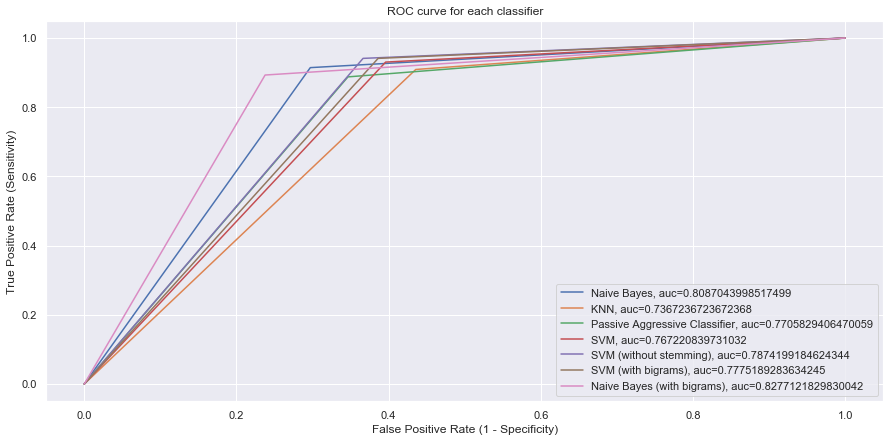

In [82]:
# Map rating to binary values
y_test_bin = y_test.replace({'positive':1,'negative':0})
pred_bin = pd.DataFrame(predicted).replace({'positive':1,'negative':0})
pred2_bin = pd.DataFrame(predicted2).replace({'positive':1,'negative':0})
pred3_bin = pd.DataFrame(predicted3).replace({'positive':1,'negative':0})
pred4_bin = pd.DataFrame(predicted4).replace({'positive':1,'negative':0})
pred5_bin = pd.DataFrame(predicted5).replace({'positive':1,'negative':0})
pred6_bin = pd.DataFrame(predicted6).replace({'positive':1,'negative':0})
pred7_bin = pd.DataFrame(predicted7).replace({'positive':1,'negative':0})
plt.figure(figsize=(15,7))
# Plot ROC curve
plt.rcParams['font.size'] = 12
plt.title('ROC curve for each classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
# Fetch ROC & AUC for Naive Bayes Classification
fpr, tpr, thresh = metrics.roc_curve(y_test_bin, pred_bin)
auc = metrics.roc_auc_score(y_test_bin, pred_bin)
plt.plot(fpr,tpr,label="Naive Bayes, auc="+str(auc))
# Fetch ROC & AUC for KNN Classification
fpr, tpr, thresh = metrics.roc_curve(y_test_bin, pred2_bin)
auc = metrics.roc_auc_score(y_test_bin, pred2_bin)
plt.plot(fpr,tpr,label="KNN, auc="+str(auc))
# Fetch ROC & AUC for Passive Aggressive Classification
fpr, tpr, thresh = metrics.roc_curve(y_test_bin, pred3_bin)
auc = metrics.roc_auc_score(y_test_bin, pred3_bin)
plt.plot(fpr,tpr,label="Passive Aggressive Classifier, auc="+str(auc))
# Fetch ROC & AUC for SVM
fpr, tpr, thresh = metrics.roc_curve(y_test_bin, pred4_bin)
auc = metrics.roc_auc_score(y_test_bin, pred4_bin)
plt.plot(fpr,tpr,label="SVM, auc="+str(auc))
# Fetch ROC & AUC for SVM without stemming
fpr, tpr, thresh = metrics.roc_curve(y_test_bin, pred5_bin)
auc = metrics.roc_auc_score(y_test_bin, pred5_bin)
plt.plot(fpr,tpr,label="SVM (without stemming), auc="+str(auc))
# Fetch ROC & AUC for SVM including bigram features
fpr, tpr, thresh = metrics.roc_curve(y_test_bin, pred6_bin)
auc = metrics.roc_auc_score(y_test_bin, pred6_bin)
plt.plot(fpr,tpr,label="SVM (with bigrams), auc="+str(auc))
# Fetch ROC & AUC for Naive Bayes including bigram features
fpr, tpr, thresh = metrics.roc_curve(y_test_bin, pred7_bin)
auc = metrics.roc_auc_score(y_test_bin, pred7_bin)
plt.plot(fpr,tpr,label="Naive Bayes (with bigrams), auc="+str(auc))
plt.legend(loc=0)
plt.show()

The above figure shows Naive Bayes with bigrams performs much better than the other classifiers with a high early true positive rate for lower false positive rates. Higher AUC also shows that Naive Bayes classifier is better. This could be because of the specific test set chosen, hence for a better comparison we perform a 10-fold validation as shown below.

### Evaluate & Compare Classifiers For Restaurant Dataset

To Compare the models, we use a cross validation using a 10-fold validation and compare the performance to confirm which is the better model.

##### Naive Bayes Classifier

In [83]:
scores = dict()
f1_scores = dict()
# Get numerical form of dataset based on model features
X = vectorizer.transform(data_2)
# Perform Cross Validation
score=cross_validate(rest_model, X, target_2, cv=10, scoring=scoring, n_jobs=-1,return_train_score=False)
# Store for plotting
scores['Naive_Bayes'] = np.mean(score['test_accuracy'])
print("Accuracy : ",np.mean(score['test_accuracy']), " +/- ", np.std(score['test_accuracy']))
# Store for plotting
f1_scores['Naive_Bayes'] = np.mean(score['test_f1_macro'])
print("F1-Score : ",np.mean(score['test_f1_macro']), " +/- ", np.std(score['test_f1_macro']))

Accuracy :  0.845182963588136  +/-  0.03256040334465983
F1-Score :  0.8335074815284675  +/-  0.031825891269316044


##### KNN Classifier

In [84]:
# Perform Cross Validation
score=cross_validate(rest_model2, X, target_2, cv=10, scoring=scoring, n_jobs=-1,return_train_score=False)
# Store for plotting
scores['KNN'] = np.mean(score['test_accuracy'])
print("Accuracy : ",np.mean(score['test_accuracy']), " +/- ", np.std(score['test_accuracy']))
# Store for plotting
f1_scores['KNN'] = np.mean(score['test_f1_macro'])
print("F1-Score : ",np.mean(score['test_f1_macro']), " +/- ", np.std(score['test_f1_macro']))

Accuracy :  0.7736286271200065  +/-  0.021794680725848458
F1-Score :  0.7457558545322902  +/-  0.02610833611250763


##### Passive Aggressive Classifier

In [85]:
# Perform Cross Validation
score=cross_validate(rest_model3, X, target_2, cv=10, scoring=scoring, n_jobs=-1,return_train_score=False)
# Store for plotting
scores['Passive Aggressive Classifier'] = np.mean(score['test_accuracy'])
print("Accuracy : ",np.mean(score['test_accuracy']), " +/- ", np.std(score['test_accuracy']))
# Store for plotting
f1_scores['Passive Aggressive Classifier'] = np.mean(score['test_f1_macro'])
print("F1-Score : ",np.mean(score['test_f1_macro']), " +/- ", np.std(score['test_f1_macro']))

Accuracy :  0.8284867574953783  +/-  0.023528210680679753
F1-Score :  0.8120972562532964  +/-  0.023484657316297956


##### SVM

In [86]:
# Perform Cross Validation
score=cross_validate(rest_model4, X, target_2, cv=10, scoring=scoring, n_jobs=-1,return_train_score=False)
# Store for plotting
scores['SVM'] = np.mean(score['test_accuracy'])
print("Accuracy : ",np.mean(score['test_accuracy']), " +/- ", np.std(score['test_accuracy']))
# Store for plotting
f1_scores['SVM'] = np.mean(score['test_f1_macro'])
print("F1-Score : ",np.mean(score['test_f1_macro']), " +/- ", np.std(score['test_f1_macro']))

Accuracy :  0.8555657704364601  +/-  0.019657161446478732
F1-Score :  0.8339736216062221  +/-  0.025920257546346668


##### SVM without stemming

#### Average Accuracy of Model 5 using a 10-fold Cross Validation

In [87]:
# Get numerical form of dataset based on model features
X = vectorizer_nostem.transform(data_2)
# Perform Cross Validation
score=cross_validate(rest_model5, X, target_2, cv=10, scoring=scoring, n_jobs=-1,return_train_score=False)
# Store for plotting
scores['SVM without stemming'] = np.mean(score['test_accuracy'])
print("Accuracy : ",np.mean(score['test_accuracy']), " +/- ", np.std(score['test_accuracy']))
# Store for plotting
f1_scores['SVM without stemming'] = np.mean(score['test_f1_macro'])
print("F1-Score : ",np.mean(score['test_f1_macro']), " +/- ", np.std(score['test_f1_macro']))

Accuracy :  0.8562457130991612  +/-  0.02443474050786684
F1-Score :  0.834120503249794  +/-  0.03216784210049075


##### SVM with bigram

#### Average Accuracy of Model 6 using a 10-fold Cross Validation

In [88]:
# Get numerical form of dataset based on model features
X = vectorizer_bi.transform(data_2)
# Perform Cross Validation
score=cross_validate(rest_model6, X, target_2, cv=10, scoring=scoring, n_jobs=-1,return_train_score=False)
# Store for plotting
scores['SVM with bigrams'] = np.mean(score['test_accuracy'])
print("Accuracy : ",np.mean(score['test_accuracy']), " +/- ", np.std(score['test_accuracy']))
# Store for plotting
f1_scores['SVM with bigrams'] = np.mean(score['test_f1_macro'])
print("F1-Score : ",np.mean(score['test_f1_macro']), " +/- ", np.std(score['test_f1_macro']))

Accuracy :  0.8555899177450902  +/-  0.022439695566163757
F1-Score :  0.8342017925798194  +/-  0.029063149518344687


##### Naive Bayes with bigram

#### Average Accuracy of Model 7 using a 10-fold Cross Validation

In [89]:
# Perform Cross Validation
score=cross_validate(rest_model7, X, target_2, cv=10, scoring=scoring, n_jobs=-1,return_train_score=False)
# Store for plotting
scores['Naive Bayes with bigrams'] = np.mean(score['test_accuracy'])
print("Accuracy : ",np.mean(score['test_accuracy']), " +/- ", np.std(score['test_accuracy']))
# Store for plotting
f1_scores['Naive Bayes with bigrams'] = np.mean(score['test_f1_macro'])
print("F1-Score : ",np.mean(score['test_f1_macro']), " +/- ", np.std(score['test_f1_macro']))

Accuracy :  0.8431142660021971  +/-  0.03483978950209106
F1-Score :  0.8332043368433011  +/-  0.0346459801479864


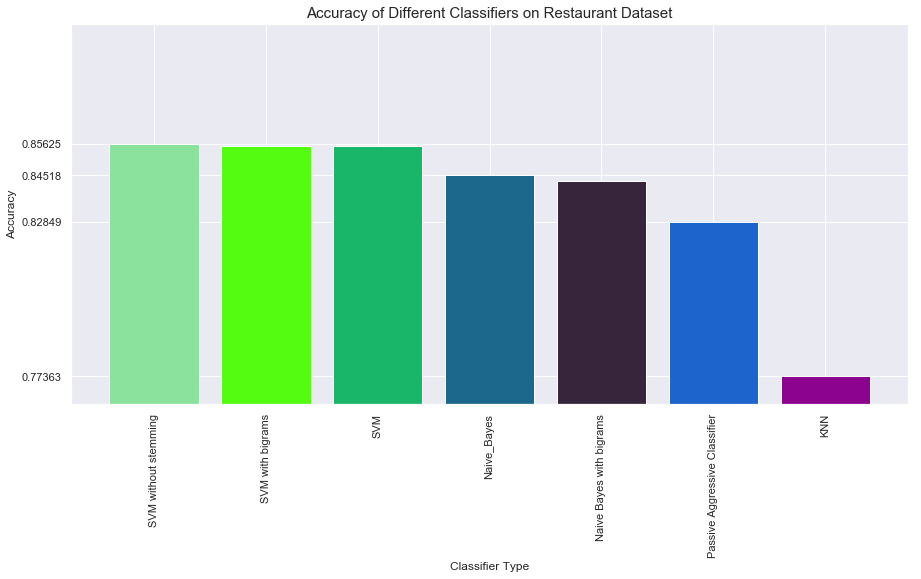

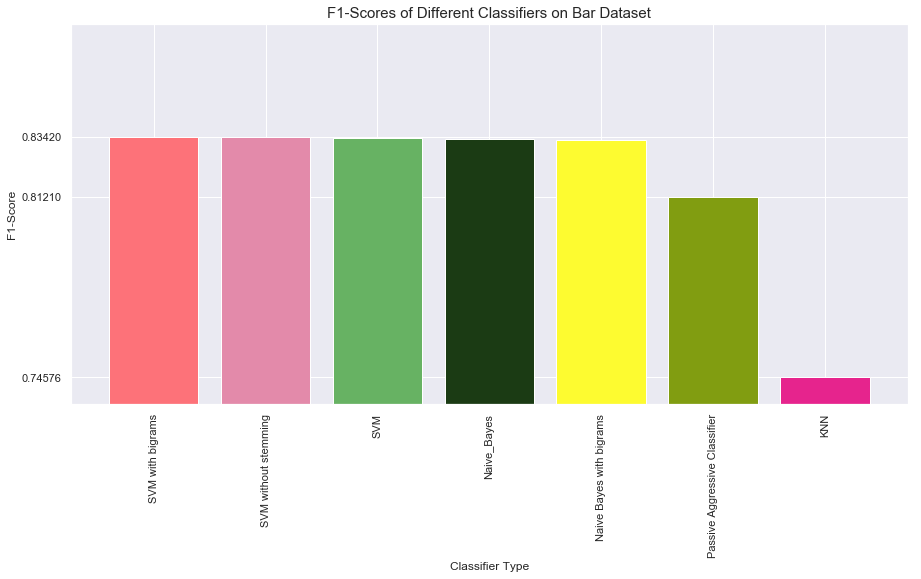

In [90]:
plot_graph(scores,"Accuracy of Different Classifiers on Restaurant Dataset",prune=True)
plot_graph(f1_scores,"F1-Scores of Different Classifiers on Bar Dataset",ytitle="F1-Score",prune=True)

We can see that SVM with bigrams and SVM with no stemming outperforms the other classifiers and can be chosen as the best model for the dataset.
We choose SVM with no stemming(It has better average accuracy by 0.1%) as the best model for later use.

In [91]:
best_rest_model = rest_model5
rest_vectorizer = vectorizer_nostem

# Task 3: Transfer Learning

Since restaurants and bars are both places to eat & drink, these datasets would have similiar reviews. This would mean both datasets have common features, hence we hypothesis that the models trained on each dataset would have a good accuracy on the other dataset.

### Classify Bars using model Trained on Restaurant Dataset

 #### Restaurant based SVM classifier on Restaurant Dataset(Test Set)

In [92]:
model = dict()
f1_model = dict()
# Predict on 20% of remaining set
pred = best_rest_model.predict(Rest_test)

##### Accuracy/F1 Score on a original dataset(restaurant data)

In [93]:
# Print metrics
acc_score = metrics.accuracy_score(Rest_test_label, pred)
f1_score = metrics.f1_score(Rest_test_label, pred, average='macro')
print('Total accuracy classification score: '+str(acc_score))
model['Restaurant Model']  = acc_score
print('Total F1 classification score: '+str(f1_score))
f1_model['Restaurant Model']  = f1_score

Total accuracy classification score: 0.8333333333333334
Total F1 classification score: 0.8036363636363637


 #### Restaurant based SVM classifier on Bar dataset

In [94]:
# Fetch bar data
bar_data = dataset1.review
bar_label = dataset1.rating
# Convert bar data into numerical format based on restaurant model
X_bar = rest_vectorizer.transform(bar_data)

#### Predict on bar data

In [95]:
# Predict using the restaurant model model
predicted = best_rest_model.predict(X_bar)

#### Evaluate the transfer learning for the restaurant model on bar dataset

##### Confusion Matrix

The confusion matrix shows the amount of predictions which were correct for each label. We can see that for the transfer model, we have 150+ items misclassified as positive when they were actually negative. We can see there are less items misclassified as negative when they were actually positive.

In [96]:
print(" Confusion Matrix on restaurant data")
display(pd.crosstab(np.array(Rest_test_label), pred, rownames=['Actual'], colnames=['Predicted'], margins=True))
print(" Confusion Matrix on bar data")
display(pd.crosstab(np.array(bar_label), predicted, rownames=['Actual'], colnames=['Predicted'], margins=True))

 Confusion Matrix on restaurant data


Predicted,negative,positive,All
Actual,,,
negative,64,37,101
positive,11,176,187
All,75,213,288


 Confusion Matrix on bar data


Predicted,negative,positive,All
Actual,,,
negative,411,154,565
positive,56,839,895
All,467,993,1460


##### Accuracy/F1 Score on a new dataset(bar data)

In [97]:
acc_score = dict()
f1_score = dict()
acc_score['Restaurant Model'] = metrics.accuracy_score(bar_label, predicted)
f1_score['Restaurant Model'] = metrics.f1_score(bar_label, predicted, average='macro')
print('Total accuracy classification score: '+str(acc_score['Restaurant Model']))
print('Total F1 classification score: '+str(f1_score['Restaurant Model']))

Total accuracy classification score: 0.8561643835616438
Total F1 classification score: 0.8426414071738273


#### Compare model between old dataset & new data

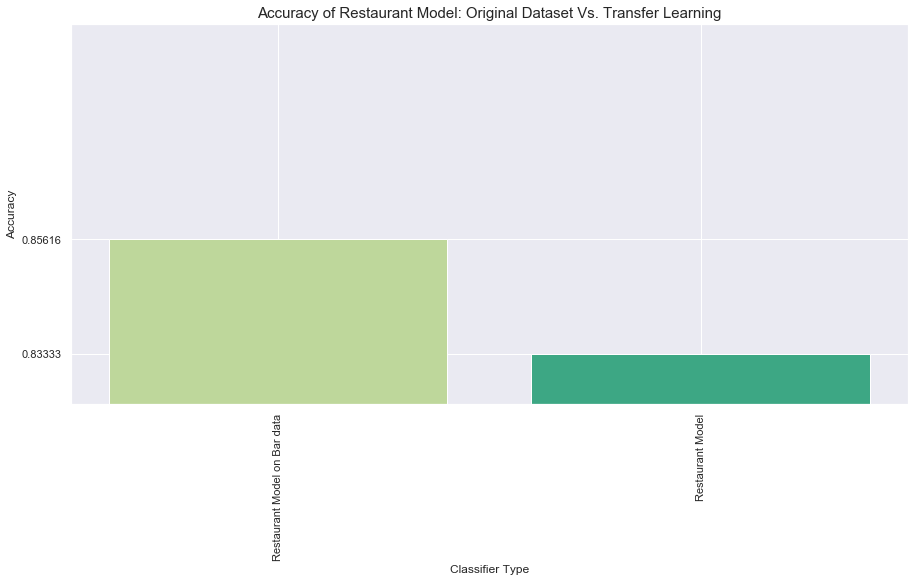

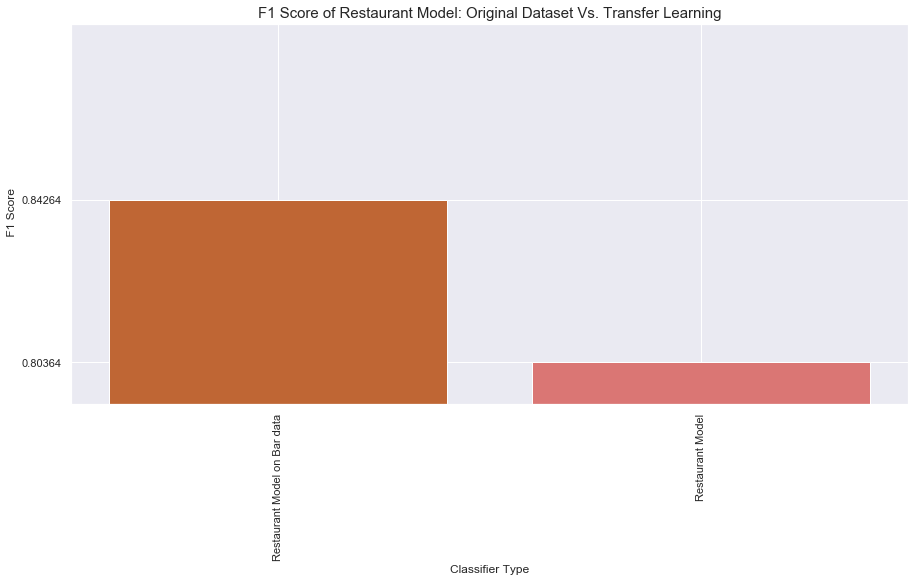

In [98]:
model['Restaurant Model on Bar data'] = acc_score['Restaurant Model']
f1_model['Restaurant Model on Bar data'] =  f1_score['Restaurant Model']
plot_graph(model,"Accuracy of Restaurant Model: Original Dataset Vs. Transfer Learning")
plot_graph(f1_model,"F1 Score of Restaurant Model: Original Dataset Vs. Transfer Learning",ytitle=" F1 Score")

#### ROC of Restaurant Model on Restaurant data vs. ROC of Restaurant model on bar data

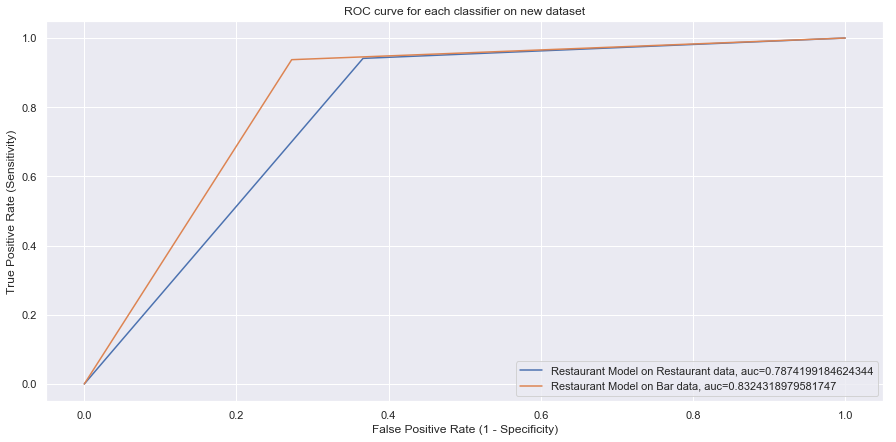

In [99]:
# Map rating to binary values
y_test_bin = Rest_test_label.replace({'positive':1,'negative':0})
y_test2_bin = bar_label.replace({'positive':1,'negative':0})
pred_bin = pd.DataFrame(pred).replace({'positive':1,'negative':0})
pred2_bin = pd.DataFrame(predicted).replace({'positive':1,'negative':0})
# Plot ROC curve
plt.figure(figsize=(15,7))
plt.rcParams['font.size'] = 12
plt.title('ROC curve for each classifier on new dataset')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
# Fetch ROC & AUC for Rest data Classification
fpr, tpr, thresh = metrics.roc_curve(y_test_bin, pred_bin)
auc = metrics.roc_auc_score(y_test_bin, pred_bin)
plt.plot(fpr,tpr,label="Restaurant Model on Restaurant data, auc="+str(auc))
# Fetch ROC & AUC for Bar data Classification
fpr, tpr, thresh = metrics.roc_curve(y_test2_bin, pred2_bin)
auc = metrics.roc_auc_score(y_test2_bin, pred2_bin)
plt.plot(fpr,tpr,label="Restaurant Model on Bar data, auc="+str(auc))
plt.legend(loc=0)
plt.show()

We can see that the transfer learning model on restaurant data has performed better than the original model. This could be because the original model is more skewed than the transfer learning model. Also the new dataset(bars) has less number of features compared to the high number features which was used to train the Restaurant model.

### Classify Restaurants using Model trained on Bars

 #### Bar Review based SVM classifier on Bar dataset(Test Set)

In [100]:
model1 = dict()
f1_model1 = dict()
# Fetch predictions for bar test set
pred2 = best_bar_model.predict(Bar_test)

##### Accuracy/F1 Score of the model on bar dataset

In [101]:
# Calculate metrics
acc_score1 = metrics.accuracy_score(Bar_test_label, pred2)
f1_score1 = metrics.f1_score(Bar_test_label, pred2, average='macro')
print('Total accuracy classification score: '+str(acc_score1))
model1['Bar Model'] = acc_score1
print('Total F1 classification score: '+str(f1_score1))
f1_model1['Bar Model']  = f1_score1

Total accuracy classification score: 0.886986301369863
Total F1 classification score: 0.8770526315789473


 #### Bar Review based SVM classifier on Restaurant Dataset

In [102]:
# Fetch bar data
rest_data = dataset2.review
rest_label = dataset2.rating
# Convert restaurant data into numerical format based on bar model
X_test = bar_vectorizer.transform(rest_data)
X_test.shape

(1440, 1218)

#### Predict on restaurant data

In [103]:
predicted2 = best_bar_model.predict(X_test)

#### Evaluate the transfer learning for the bar model on restaurant dataset

##### Confusion Matrix

The confusion matrix shows the amount of predictions which were correct for each label. We can see that we have 130+ items misclassified as positive when they were actually negative. We can see there are less items misclassified as negative when they were actually positive.

In [104]:
print("Confusion Matrix On Bar Data")
display(pd.crosstab(np.array(Bar_test_label), pred2, rownames=['Actual'], colnames=['Predicted'], margins=True))
print("Confusion Matrix On Restaurant Data")
display(pd.crosstab(np.array(rest_label), predicted2, rownames=['Actual'], colnames=['Predicted'], margins=True))

Confusion Matrix On Bar Data


Predicted,negative,positive,All
Actual,,,
negative,88,25,113
positive,8,171,179
All,96,196,292


Confusion Matrix On Restaurant Data


Predicted,negative,positive,All
Actual,,,
negative,370,137,507
positive,74,859,933
All,444,996,1440


##### Accuracy/F1 Score of the model prediction on restaurant dataset

In [105]:
acc_score['Bar model'] = metrics.accuracy_score(rest_label, predicted2)
f1_score['Bar model'] = metrics.f1_score(rest_label, predicted2, average='macro')
print('Total accuracy classification score: '+str(acc_score['Bar model']))
print('Total F1 classification score: '+str(f1_score['Bar model']))

Total accuracy classification score: 0.8534722222222222
Total F1 classification score: 0.8343725929814405


#### Compare with original model

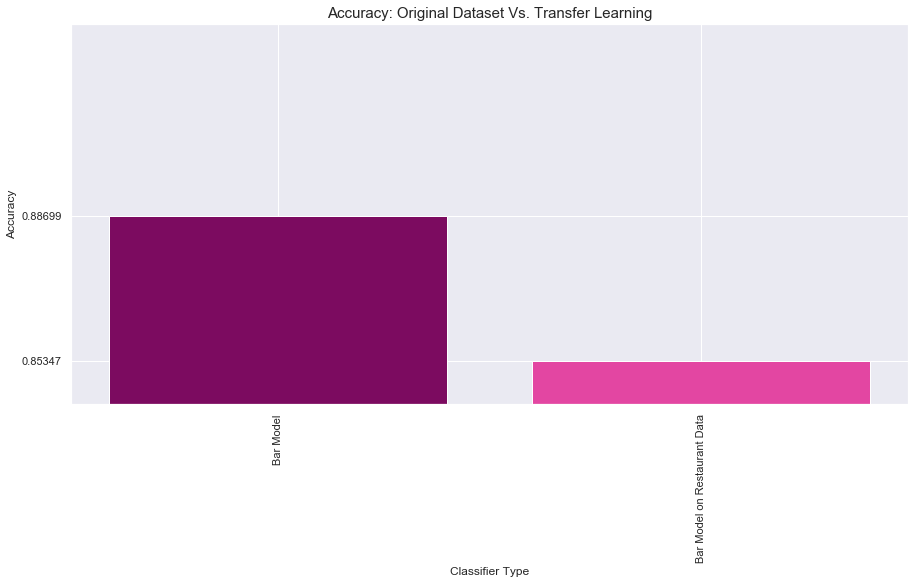

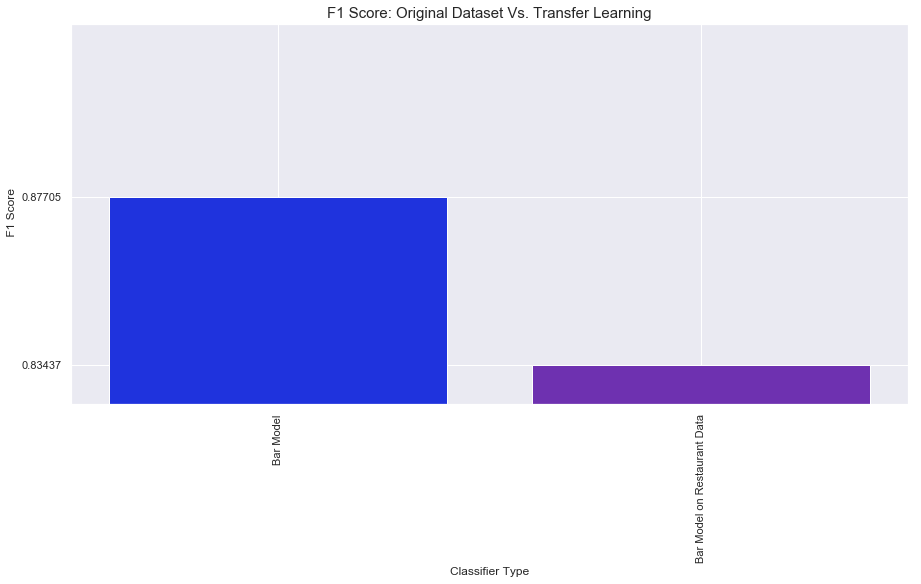

In [106]:
model1['Bar Model on Restaurant Data'] = acc_score['Bar model']
f1_model1['Bar Model on Restaurant Data'] = f1_score['Bar model']
plot_graph(model1,"Accuracy: Original Dataset Vs. Transfer Learning")
plot_graph(f1_model1,"F1 Score: Original Dataset Vs. Transfer Learning",ytitle=" F1 Score")

#### ROC of Bar Model on Bar data vs. ROC of bar model on Restaurant data

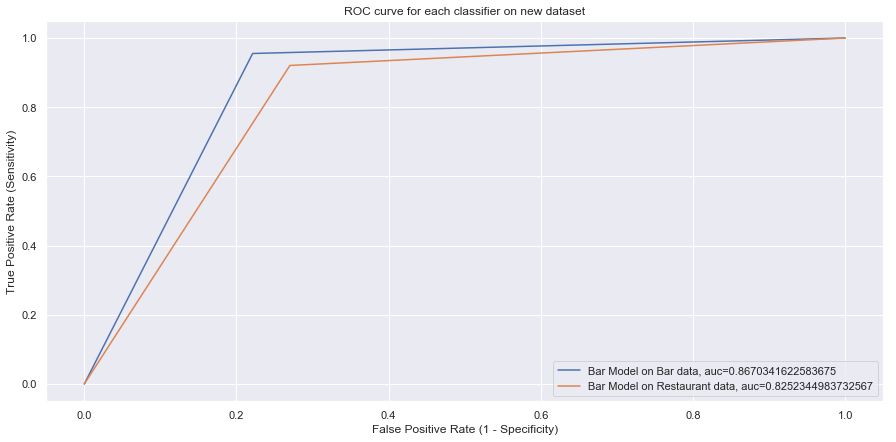

In [107]:
# Map rating to binary values
y_test_bin = Bar_test_label.replace({'positive':1,'negative':0})
y_test2_bin = rest_label.replace({'positive':1,'negative':0})
pred_bin = pd.DataFrame(pred2).replace({'positive':1,'negative':0})
pred2_bin = pd.DataFrame(predicted2).replace({'positive':1,'negative':0})
# Plot ROC curve
plt.figure(figsize=(15,7))
plt.rcParams['font.size'] = 12
plt.title('ROC curve for each classifier on new dataset')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
# Fetch ROC & AUC for bar data Classification
fpr, tpr, thresh = metrics.roc_curve(y_test_bin, pred_bin)
auc = metrics.roc_auc_score(y_test_bin, pred_bin)
plt.plot(fpr,tpr,label="Bar Model on Bar data, auc="+str(auc))
# Fetch ROC & AUC for rest data Classification
fpr, tpr, thresh = metrics.roc_curve(y_test2_bin, pred2_bin)
auc = metrics.roc_auc_score(y_test2_bin, pred2_bin)
plt.plot(fpr,tpr,label="Bar Model on Restaurant data, auc="+str(auc))
plt.legend(loc=0)
plt.show()

We can see that the transfer learning model trained on bar data performs well enough but not better on restaurant data. This could be because restaurant dataset covers more features than bar dataset and might require more features to be more accurate.

### Comparison of both Transfer Learning models

#### Accuracy of both models

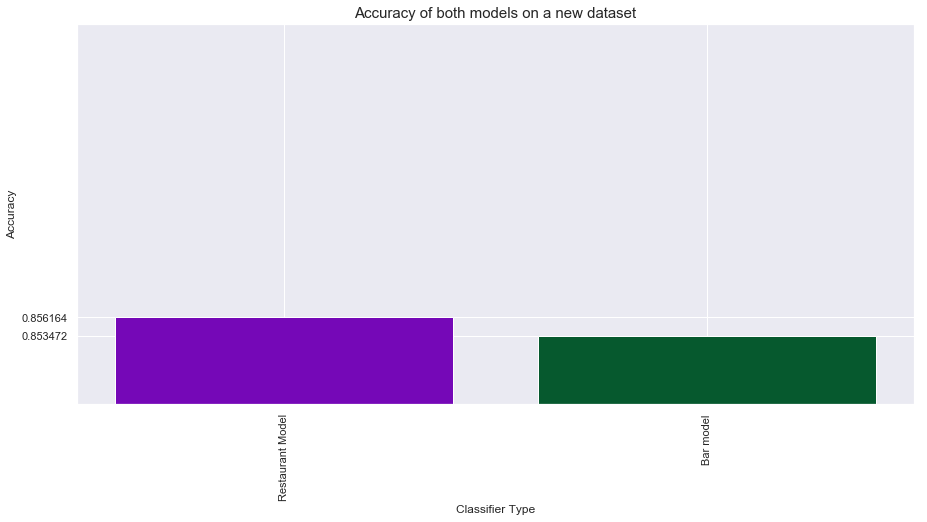

In [108]:
plot_graph(acc_score,"Accuracy of both models on a new dataset")

#### F1-Score of both models

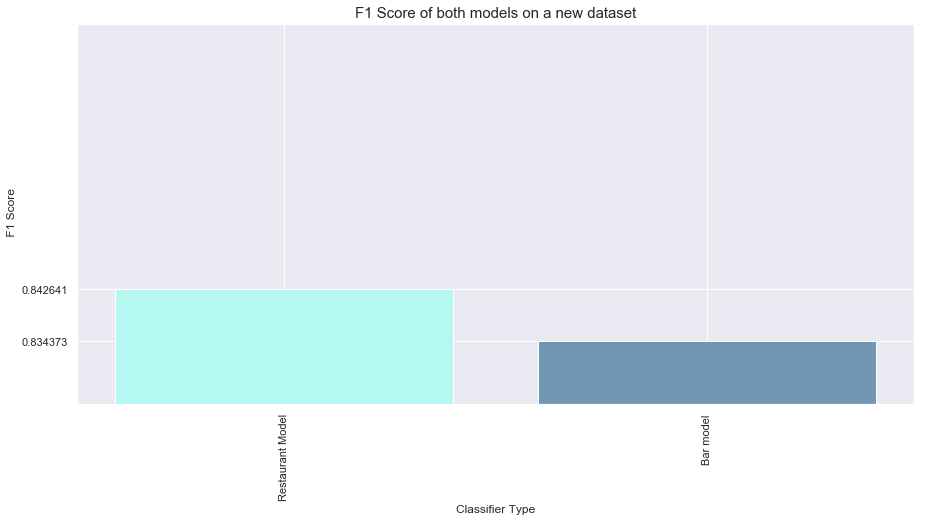

In [109]:
plot_graph(f1_score,"F1 Score of both models on a new dataset",ytitle=" F1 Score")

We can see the restaurant model outperforms the bar model on transfer learning. This could be because bars could be a subset of restaurants therefore restaurant dataset was able to capture most of the important features in the bar dataset.

#### ROC of both models

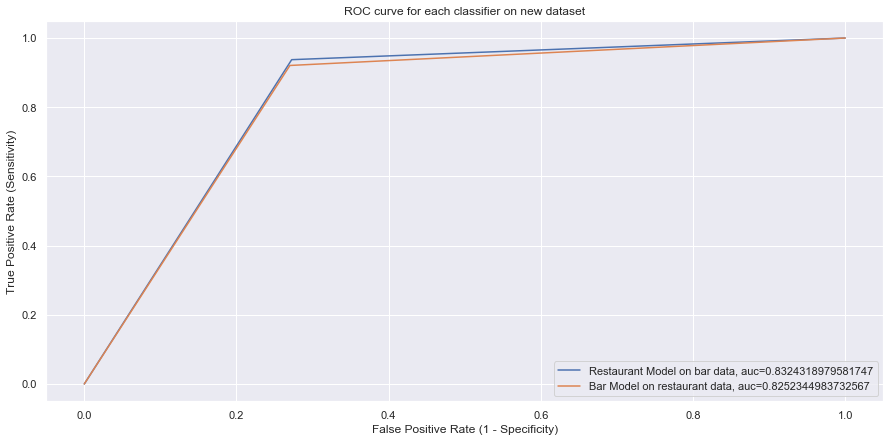

In [110]:
# Map rating to binary values
y_test_bin = bar_label.replace({'positive':1,'negative':0})
y_test2_bin = rest_label.replace({'positive':1,'negative':0})
pred_bin = pd.DataFrame(predicted).replace({'positive':1,'negative':0})
pred2_bin = pd.DataFrame(predicted2).replace({'positive':1,'negative':0})
# Plot ROC curve
plt.figure(figsize=(15,7))
plt.rcParams['font.size'] = 12
plt.title('ROC curve for each classifier on new dataset')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
# Fetch ROC & AUC for Rest Classification
fpr, tpr, thresh = metrics.roc_curve(y_test_bin, pred_bin)
auc = metrics.roc_auc_score(y_test_bin, pred_bin)
plt.plot(fpr,tpr,label="Restaurant Model on bar data, auc="+str(auc))
# Fetch ROC & AUC for Bar Classification
fpr, tpr, thresh = metrics.roc_curve(y_test2_bin, pred2_bin)
auc = metrics.roc_auc_score(y_test2_bin, pred2_bin)
plt.plot(fpr,tpr,label="Bar Model on restaurant data, auc="+str(auc))
plt.legend(loc=0)
plt.show()

### Conclusion

Initial analysis shows that SVM & Naive Bayes performs exceptionally well than other classifiers in the area of text classification. We can see the best models on the two datasets perform good transfer learning. Our hypothesis is valid since both classifiers have good rate of transfer learning due to their similarities.